In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, roc_auc_score
import swifter

import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import tensorflow as tf 

print(tf. __version__)

from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import TextVectorization
nltk.download('stopwords')

import visualkeras

2.8.0
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load and Preprocess

In [ ]:
# import zipfile
# with zipfile.ZipFile("splr.zip", 'r') as zip_ref:
#     zip_ref.extractall("data")

# import zipfile
# with zipfile.ZipFile("glove.6B.50d.txt.zip", 'r') as zip_ref:
#     zip_ref.extractall("data")

In [ ]:
df_reviews = pd.read_json('data/IMDB_reviews.json', lines=True)
df_details = pd.read_json('data/IMDB_movie_details.json', lines=True)

In [ ]:
df_reviews.is_spoiler.value_counts()

False    422989
True     150924
Name: is_spoiler, dtype: int64

In [ ]:
df = pd.merge(df_reviews[['movie_id','review_text','is_spoiler']], df_details[['movie_id','plot_summary']], on='movie_id')
df = pd.concat([df[df.is_spoiler].sample(frac=1, replace=True), df[~df.is_spoiler].sample(frac=0.35)]).sample(frac=1).reset_index(drop=True)
#df = df.groupby('is_spoiler', group_keys=False).apply(lambda x: x.sample(frac=0.5))
df['is_spoiler'] = (df['is_spoiler'] == True).astype(int)
df = df[['review_text','plot_summary','is_spoiler']]
print(df.shape)
df.head()

(298968, 3)


,review_text,plot_summary,is_spoiler
0,Whine whine whine and complain about this movi...,Willie T. Stokes is a convicted con man who's ...,0
1,I never saw any of the old series (which was n...,"The Doctor, a Time Lord/Lady from the race who...",1
2,I had to write a review the average is six in ...,"Stranded after a tragic plane crash, two stran...",0
3,"I am a native japanese residing in Tokyo, very...","In the 1870s, Captain Nathan Algren, a cynical...",0
4,This was a fill-in movie that was impressive a...,Unable to cope with reality and the difficulty...,0


In [ ]:
df.is_spoiler.value_counts()

1    150924
0    148044
Name: is_spoiler, dtype: int64

In [ ]:
sw = stopwords.words('english')
ps = PorterStemmer()

def preprocess_text(review):
    review = review.lower() # Convert to lowercase
    review = re.sub('[^a-zA-Z]',' ', review) # Remove words with non-letter characters
    words = review.split()
    words = [word for word in words if word not in sw] # Remove stop words
    review = " ".join(words)
    return review

In [ ]:
df['review_text'] = df['review_text'].swifter.apply(preprocess_text)
df['plot_summary'] = df['plot_summary'].swifter.apply(preprocess_text)

Pandas Apply:   0%|          | 0/298968 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/298968 [00:00<?, ?it/s]

### Train test split

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.25, stratify=df['is_spoiler'])

### Create text vectorizer

In [ ]:
review_lens = [len(sentence.split()) for sentence in train_df['review_text']]
plot_lens = [len(sentence.split()) for sentence in train_df['plot_summary']]

In [ ]:
train_sentences = list(pd.concat([train_df['review_text'], train_df['plot_summary']]))
train_reviews = list(train_df['review_text'])
train_plots = list(train_df['plot_summary'])
train_labels = list(train_df['is_spoiler'])

In [ ]:
val_reviews = list(val_df['review_text'])
val_plots = list(val_df['plot_summary'])
val_labels = list(val_df['is_spoiler'])

In [ ]:
avg_review_len, avg_plot_len = np.mean(review_lens), np.mean(plot_lens)
avg_review_len, avg_plot_len

(146.01325448431493, 59.655468143747825)

In [ ]:
max_tokens = 50000
output_seq_len = int(max(avg_review_len, avg_plot_len))

In [ ]:
del df_reviews
del df_details
del df

In [ ]:
text_vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=output_seq_len)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
text_vocab = text_vectorizer.get_vocabulary()

In [ ]:
del train_sentences

### Create dataset

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(((train_reviews, train_plots), train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices(((val_reviews, val_plots), val_labels))

In [ ]:
train_dataset = train_dataset.batch(512).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(512).prefetch(tf.data.AUTOTUNE)

### Create Model

In [ ]:
class TextCNN(tf.keras.Model):

    def __init__(self,
                 token_embed,
                 text_vectorizer,
                 kernel_sizes,
                 dropout_rate=0.4,
                 dilation_rate=1
                 ):
        super(TextCNN, self).__init__()
        self.token_embed = token_embed
        self.text_vectorizer = text_vectorizer
        self.kernel_sizes = kernel_sizes
        self.convs = []
        
        self.bi_lstm = layers.Bidirectional(layers.LSTM(16, return_sequences=True, return_state=False))

        for i, kernel_size in enumerate(self.kernel_sizes):
            self.convs.append(layers.Conv1D(16, kernel_size, activation='relu', dilation_rate=dilation_rate))
        
        self.max_pooling = layers.GlobalMaxPooling1D()
        
        self.classifier = tf.keras.Sequential(
                    [
                      layers.Dropout(dropout_rate),
                      layers.Dense(64, activation="relu"),
                      layers.Dropout(dropout_rate),
                      layers.Dense(64, activation="relu")
                    ]
                  )
        
        self.attention = layers.Attention(use_scale=True)
        
        self.similarity = tf.keras.Sequential(
                    [
                      layers.Dot(axes=1, normalize=True),
                      layers.Dense(1, activation="sigmoid")
                    ]
                  )

    def call(self, inputs):

        review_inputs, plot_inputs = inputs
        
        review_vectors = self.text_vectorizer(review_inputs)
        plot_vectors = self.text_vectorizer(plot_inputs)
        
        review_embeddings = self.token_embed(review_vectors)
        plot_embeddings = self.token_embed(plot_vectors)
        
        review_embeddings_bilstm = self.bi_lstm(review_embeddings)
        plot_embeddings_bilstm = self.bi_lstm(plot_embeddings) 
        
        r = layers.Dropout(0.2)(review_embeddings_bilstm)
        for i, k in enumerate(self.kernel_sizes):
            r = self.convs[i](r)
        
        r = self.max_pooling(r)
        r = self.attention([r,r])
        r = self.classifier(r)
        
        p = layers.Dropout(0.2)(plot_embeddings_bilstm)
        for i, k in enumerate(self.kernel_sizes):
            p = self.convs[i](p)
        
        p = self.max_pooling(p)
        p = self.attention([p,p])
        p = self.classifier(p)
        
        output = self.similarity([r, p])
        
        return output

### Create embeddings

In [ ]:
embeddings_index = dict()
f = open('data/glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
embedding_matrix = np.zeros((len(text_vocab), 50))
for i, word in enumerate(text_vocab):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
token_embed = layers.Embedding(input_dim=len(text_vocab), output_dim=50, mask_zero=True, weights=[embedding_matrix], trainable=True)

### Train the model

In [ ]:
model = TextCNN(token_embed, text_vectorizer, kernel_sizes=[2], dilation_rate=1)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
history_model_textcnn = model.fit(train_dataset, steps_per_epoch=len(train_dataset),
                              epochs=50, 
                              validation_data=val_dataset, 
                              shuffle=True,
                              validation_steps=len(val_dataset)
                              )

Epoch 1/50
438/438 [==============================] - 56s 96ms/step - loss: 0.6825 - accuracy: 0.5573 - val_loss: 0.6376 - val_accuracy: 0.6810
Epoch 2/50
438/438 [==============================] - 38s 86ms/step - loss: 0.5997 - accuracy: 0.7239 - val_loss: 0.6238 - val_accuracy: 0.6767
Epoch 3/50
438/438 [==============================] - 38s 86ms/step - loss: 0.5663 - accuracy: 0.7514 - val_loss: 0.6127 - val_accuracy: 0.6919
Epoch 4/50
438/438 [==============================] - 38s 86ms/step - loss: 0.5479 - accuracy: 0.7642 - val_loss: 0.6053 - val_accuracy: 0.7074
Epoch 5/50
438/438 [==============================] - 38s 86ms/step - loss: 0.5364 - accuracy: 0.7720 - val_loss: 0.6074 - val_accuracy: 0.7081
Epoch 6/50
438/438 [==============================] - 37s 86ms/step - loss: 0.5260 - accuracy: 0.7793 - val_loss: 0.6067 - val_accuracy: 0.7117
Epoch 7/50
438/438 [==============================] - 37s 86ms/step - loss: 0.5196 - accuracy: 0.7842 - val_loss: 0.6087 - val_accuracy:

### Evaluation

In [ ]:
y_pred = np.ravel(model.predict((np.array(val_reviews),np.array(val_plots))))

In [ ]:
y_pred_max = (y_pred>0.35)+0
print(classification_report(val_labels, y_pred_max))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71     37011
           1       0.71      0.73      0.72     37731

    accuracy                           0.72     74742
   macro avg       0.72      0.72      0.72     74742
weighted avg       0.72      0.72      0.72     74742



In [ ]:
cf = confusion_matrix(val_labels, y_pred_max)
print(cf)

[[25971 11040]
 [10062 27669]]


In [ ]:
def plot_roc(y_pred,y):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y))]
    
    # predict probabilities
    probs = y_pred
    
    # calculate scores
    ns_auc = roc_auc_score(y, ns_probs)
    auc = roc_auc_score(y, probs)
    
    # summarize scores
    #print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print(f'ROC AUC=%.3f' % (auc))
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    fpr, tpr, _ = roc_curve(y, probs)
    
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Random')
    plt.plot(fpr, tpr, marker='.')
    
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve (AUC=0.74)")
    
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

ROC AUC=0.734


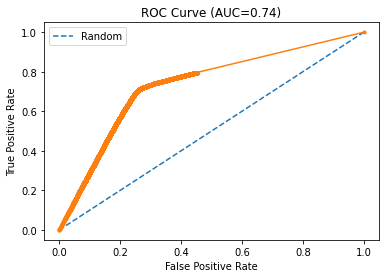

In [ ]:
plot_roc(y_pred, val_labels)